## Figure3: PPL on Medicine Domain using SmolLM2-1.7B

In [2]:
import json
import json
import matplotlib.pyplot as plt
import pandas as pd

baseline_color = "#00000099"
cpt_color = "#E63946"
cpt_it_color = "#FF6600"
instpt_color = "#009E73"
tel_color = "#007ACC"

title_font_size = 30
title_pad = 10
ticks_font_size = 16
label_font_size = 28
legend_font_size = 18
legend_title_font_size = 22

font_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"
prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

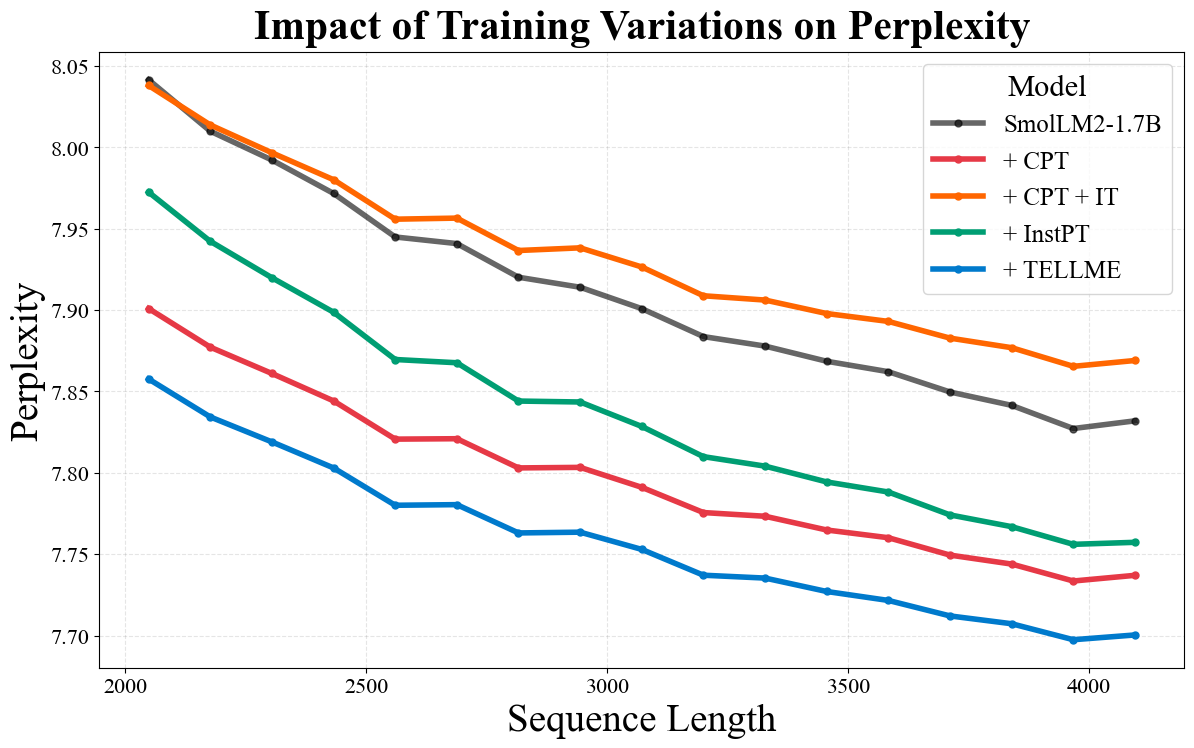

In [5]:
model_files = {
    "SmolLM2-1.7B": "../records/Main_figure3_perplexity/SmolLM2-1.7B.json",
    "+ CPT": "../records/Main_figure3_perplexity/SmolLM2-1.7B-CPT.json",
    "+ CPT + IT": "../records/Main_figure3_perplexity/SmolLM2-1.7B-CPT-SFT.json",
    "+ InstPT": "../records/Main_figure3_perplexity/SmolLM2-1.7B-inst-pt.json",
    "+ TELLME": "../records/Main_figure3_perplexity/SmolLM2-1.7B-TEL.json",
}

all_data = []

model_colors = {
    "SmolLM2-1.7B": baseline_color,
    "+ CPT": cpt_color,
    "+ CPT + IT": cpt_it_color,
    "+ InstPT": instpt_color,
    "+ TELLME": tel_color,
}

for model_name, json_path in model_files.items():
    with open(json_path, 'r') as f:
        results = json.load(f)
        for x in range(128, 2048, 128):
            results.pop(f'pubmed-seq{x}', None)
    
    for key, value in dict(sorted(results.items(), key=lambda x:int(x[0].split("-seq")[-1]))).items():
        seq_len_str = key.split("seq")[-1]
        seq_len = int(seq_len_str)
        all_data.append({
            "Sequence Length": seq_len,
            "Perplexity": value,
            "Model": model_name.strip()  
        })

df = pd.DataFrame(all_data)

plt.figure(figsize=(14, 8))

for model in df['Model'].unique():
    sub_df = df[df['Model'] == model]
    plt.plot(sub_df['Sequence Length'],
             sub_df['Perplexity'],
             'o-',
             markersize=5,
             linewidth=4,
             label=model,
             color=model_colors[model])

plt.xlabel('Sequence Length', fontsize=label_font_size)
plt.ylabel('Perplexity', fontsize=label_font_size)
plt.title('Impact of Training Variations on Perplexity', fontweight='demibold', fontsize=title_font_size, pad=title_pad)
plt.legend(title="Model", loc="upper right", fontsize=legend_font_size, title_fontsize=legend_title_font_size)
plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)
plt.grid(color='gray', linestyle='--', linewidth=0.8, alpha=0.2)
plt.savefig("perplexity_medical_smollm2_1.7B.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Figure 4

Comparison of long-term retention between CPT and TELLME in the finance domain. The top plot shows the perplexity over training steps using Bloomberg evaluation corpus, while the bottom plot presents the average score on the finance benchmark.

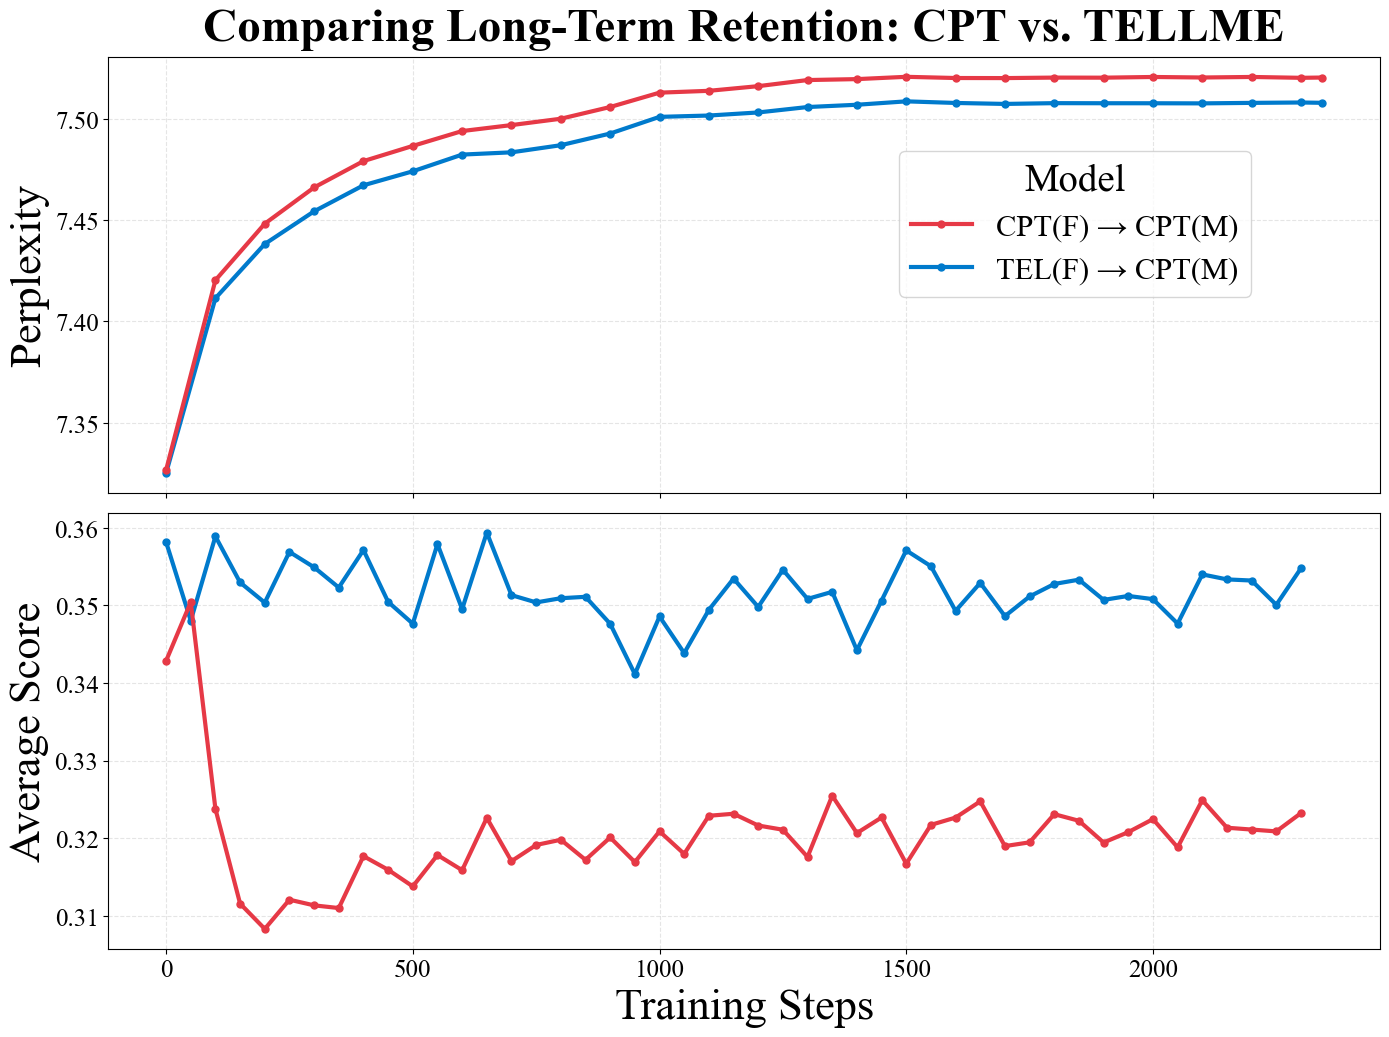

In [4]:
with open("../records/Main_figure4_long_term_retention/SmolLM2-1.7B-TEL-ovw-medicine.json", 'r') as f:
    results_tel = dict(sorted(json.load(f).items(), key=lambda x: int(x[0].split("-")[-1])))

with open("../records/Main_figure4_long_term_retention/SmolLM2-1.7B-CPT-ovw-medicine.json", 'r') as f:
    results_cpt = dict(sorted(json.load(f).items(), key=lambda x: int(x[0].split("-")[-1])))

train_steps_ppl_tel = list(map(int, [k.split("-")[-1] for k in results_tel.keys()]))
ppl_tel = list(results_tel.values())

train_steps_ppl_cpt = list(map(int, [k.split("-")[-1] for k in results_cpt.keys()]))
ppl_cpt = list(results_cpt.values())

json_file_path = "../records/Main_figure4_long_term_retention/finance_medical_finance_results.json"
with open(json_file_path, 'r', encoding='UTF-8-sig') as f:
    data = json.load(f)

checkpoints = []
avg_scores_cpt = []
avg_scores_tel = []

for entry in data:
    for checkpoint_str, models in entry.items():
        checkpoint = int(checkpoint_str)
        if checkpoint % 50 == 0:
            checkpoints.append(checkpoint)
            
            if 'CPT_ovw_medicine_CPT' in models:
                avg_cpt = (
                    models['CPT_ovw_medicine_CPT']['tel_fomc'] +
                    models['CPT_ovw_medicine_CPT']['tel_nifty'] +
                    models['CPT_ovw_medicine_CPT']['mmlu']
                ) / 3
                avg_scores_cpt.append(avg_cpt)
            else:
                avg_scores_cpt.append(None)

            if 'TEL_ovw_medicine_CPT' in models:
                avg_tel = (
                    models['TEL_ovw_medicine_CPT']['tel_fomc'] +
                    models['TEL_ovw_medicine_CPT']['tel_nifty'] +
                    models['TEL_ovw_medicine_CPT']['mmlu']
                ) / 3
                avg_scores_tel.append(avg_tel)
            else:
                avg_scores_tel.append(None)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(train_steps_ppl_tel, ppl_tel,
         marker='o', markersize=5, linestyle='-', color=tel_color,
         label='TEL(F) → CPT(M)', linewidth=3)
ax1.plot(train_steps_ppl_cpt, ppl_cpt,
         marker='o', markersize=5, linestyle='-', color=cpt_color,
         label='CPT(F) → CPT(M)', linewidth=3)

ax1.set_ylabel('Perplexity', fontsize=label_font_size+4)
ax1.tick_params(axis='both', labelsize=ticks_font_size+2)
ax1.grid(color='gray', linestyle='--', linewidth=0.8, alpha=0.2)

ax2.plot(checkpoints, avg_scores_tel,
         marker='o', linestyle='-', color=tel_color,
         label='TELLME + overwrite medicine', linewidth=3, markersize=5)
ax2.plot(checkpoints, avg_scores_cpt,
         marker='o', linestyle='-', color=cpt_color,
         label='CPT + overwrite medicine', linewidth=3, markersize=5)

ax2.set_xlabel('Training Steps', fontsize=label_font_size+4)
ax2.set_ylabel('Average Score', fontsize=label_font_size+4)
ax2.tick_params(axis='both', labelsize=ticks_font_size+2)
ax2.grid(color='gray', linestyle='--', linewidth=0.8, alpha=0.2)


lines1, labels1 = ax1.get_legend_handles_labels()

ax1.legend(lines1[::-1], labels1[::-1],
           loc='upper center', bbox_to_anchor=(0.76, .82), 
           ncol=1, fontsize=legend_font_size+4, title="Model", title_fontsize=legend_title_font_size+6)


plt.tight_layout()
plt.title('Comparing Long-Term Retention: CPT vs. TELLME', fontweight='demibold', fontsize=title_font_size+4, pad=340)
plt.savefig("long_term_retention.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Figure 6: Cost Efficient leaerning on TELLME

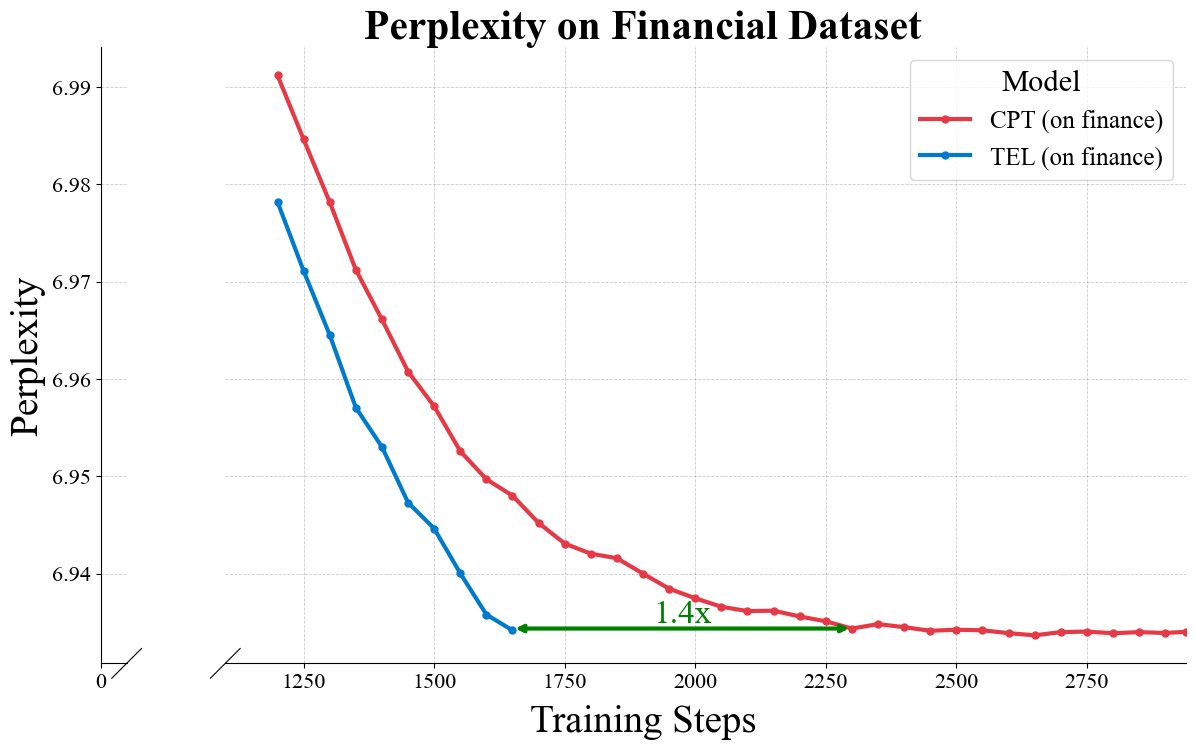

In [5]:
import json
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

with open("../records/Main_figure5_CPT_vs_TEL/SmolLM2-1.7B-TEL-on-finance-scaling.json", 'r') as f:
    results_tel = dict(sorted(json.load(f).items(), key = lambda x: int(x[0].split("-")[-1])))
 
with open("../records/Main_figure5_CPT_vs_TEL/SmolLM2-1.7B-CPT-on-finance-scaling.json", 'r') as f:
    results_cpt = dict(sorted(json.load(f).items(), key = lambda x: int(x[0].split("-")[-1])))


x_tel_all = sorted([int(key.split("-")[-1]) for key in results_tel.keys()])
x_cpt_all = sorted([int(key.split("-")[-1]) for key in results_cpt.keys()])

x_tel = [x for x in x_tel_all if x >= 1200]
x_cpt = [x for x in x_cpt_all if x >= 1200]
plt.figure(figsize=(14, 8))

bax = brokenaxes(xlims=((0, 50), (1100, max(x_tel))), hspace=0.05)

marker_size = 5

y_cpt = [results_cpt[f"checkpoint-{x}"] for x in x_cpt]
bax.plot(x_cpt, y_cpt, marker='o', linestyle='-', color=cpt_color, linewidth=3,
            markersize=marker_size, label='CPT (on finance)')
x_tel_before = [x for x in x_tel if x < 1700]
y_tel_before = [results_tel[f"checkpoint-{x}"] for x in x_tel_before]
bax.plot(x_tel_before, y_tel_before, marker='o', linestyle='-', color=tel_color, linewidth=3,
            markersize=marker_size, label='TEL (on finance)')

x_tel_after = [x for x in x_tel if x >= 1650]
y_tel_after = [results_tel[f"checkpoint-{x}"] for x in x_tel_after]

value_1650 = results_tel["checkpoint-1650"]



tel_1650 = 1650
tel_1650_val = results_tel[f"checkpoint-{tel_1650}"]

cpt_2300 = 2300
cpt_2300_val = results_cpt[f"checkpoint-{cpt_2300}"]

bax.annotate(
    "",  
    xy=(cpt_2300, cpt_2300_val),
    xytext=(tel_1650, cpt_2300_val),
    arrowprops=dict(
        arrowstyle='<->',  
        color='green',
        lw=3
    )
)

mid_x = (tel_1650 + cpt_2300) / 2
mid_y = (tel_1650_val + cpt_2300_val) / 2

bax.text(
    mid_x, mid_y,
    "1.4x",
    fontsize=24, color='green',
    ha='center', va='bottom',
)

bax.set_xlabel('Training Steps', fontsize=label_font_size, labelpad=30)
bax.set_ylabel('Perplexity', fontsize=label_font_size, labelpad=40)
for ax in bax.axs:
    ax.tick_params(axis='x', labelsize=ticks_font_size) 
    ax.tick_params(axis='y', labelsize=ticks_font_size) 

bax.legend(title="Model", fontsize=legend_font_size, title_fontsize=legend_title_font_size)
bax.grid(color='gray', linestyle='--', linewidth=0.6, alpha=0.4)

plt.title("Perplexity on Financial Dataset", fontweight='demibold', fontsize=title_font_size)
plt.savefig("perplexity_cost.pdf", bbox_inches='tight', dpi=300)
plt.show()
